## 1) Importing modules & dataframe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

import linear_regression as lr
import utils

In [2]:
df = pd.read_csv('./insurance.csv')

## 2) Preprocessing

### 2.1) Checking out our data

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


age, sex, children, smoker, region are categorical columns and bmi, charges are continuous columns.  

We have to predict charges given the rest of the features. And because charges is a continuous variable, this is a regression problem.

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### 2.2) Dealing with missing values

In [5]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
(df == "?").sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We don't have any missing values. So we are good to go!

### 2.3) Dealing with categorical and non-numeric data

We have three categorical and non-numeric columns here - sex, smoker & region. We will do one-hot encoding for them.

In [7]:
column_names_to_one_hot = ['sex', 'smoker', 'region']
df = pd.get_dummies(df, columns=column_names_to_one_hot, drop_first=True)

drop_first is set to True in pd.get_dummies() to avoid 'Dummy Variable Trap'. Read more about it here: https://www.learndatasci.com/glossary/dummy-variable-trap/

In [8]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


### 2.4) Dropping duplicate rows

In [9]:
# Checking for duplicate rows
df.duplicated().sum()

1

We have just one duplicate row. Let's drop that row.

In [10]:
df.drop(axis='rows', labels=df.index[df.duplicated()], inplace=True)
df.reset_index(inplace=True, drop=True)

In [11]:
df.duplicated().sum()

0

We have no duplicate rows now!

## 3) EDA

### 3.1) Outlier detection and removal

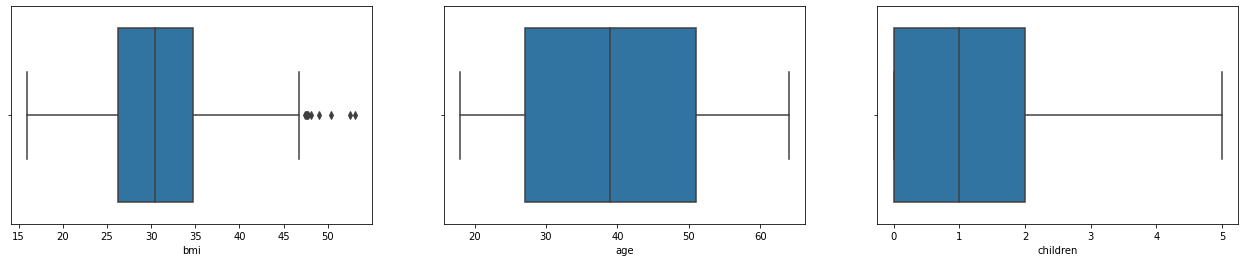

In [12]:
# Detecting outliers in bmi, age and children columns
fig, ax = plt.subplots(1, 3, figsize=(22, 4))
sns.boxplot(ax=ax[0], x=df['bmi'])
sns.boxplot(ax=ax[1], x=df['age'])
sns.boxplot(ax=ax[2], x=df['children'])
plt.show()

In [13]:
# Removing outliers from bmi
utils.remove_outlier(df, 'bmi')

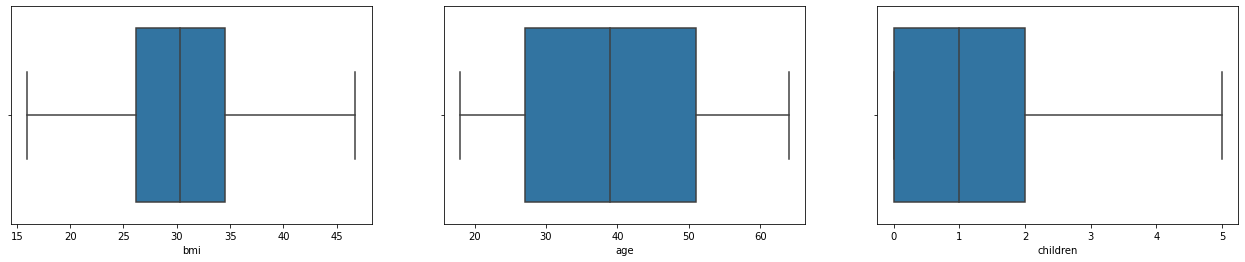

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))
sns.boxplot(ax=ax[0], x=df['bmi'])
sns.boxplot(ax=ax[1], x=df['age'])
sns.boxplot(ax=ax[2], x=df['children'])
plt.show()

### 3.2) Correlation

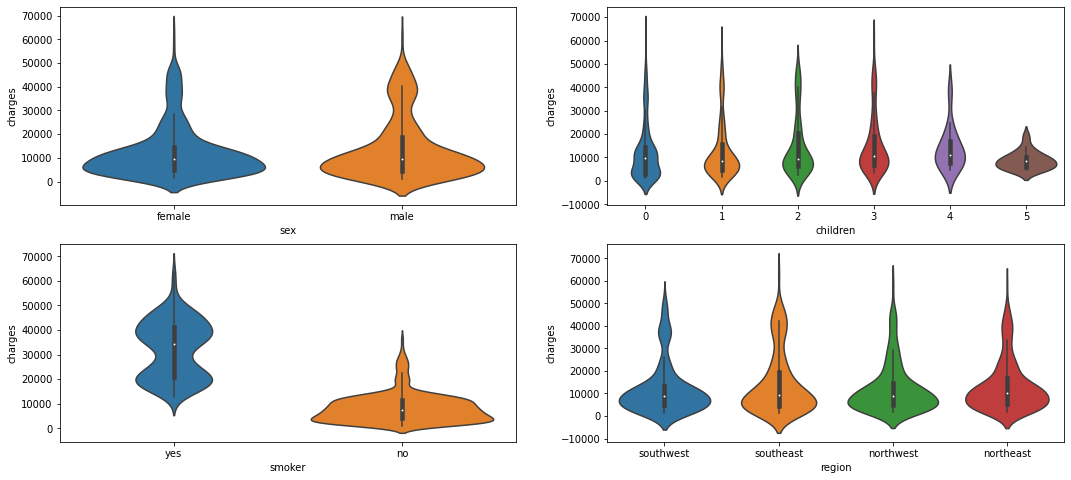

In [15]:
main_df = pd.read_csv('./insurance.csv')

fig, ax = plt.subplots(2, 2, figsize=(18, 8))
sns.violinplot(ax=ax[0,0], x="sex", y="charges", data=main_df)
sns.violinplot(ax=ax[0,1], x="children", y="charges", data=main_df)
sns.violinplot(ax=ax[1,0], x="smoker", y="charges", data=main_df)
sns.violinplot(ax=ax[1,1], x="region", y="charges", data=main_df)
plt.show()

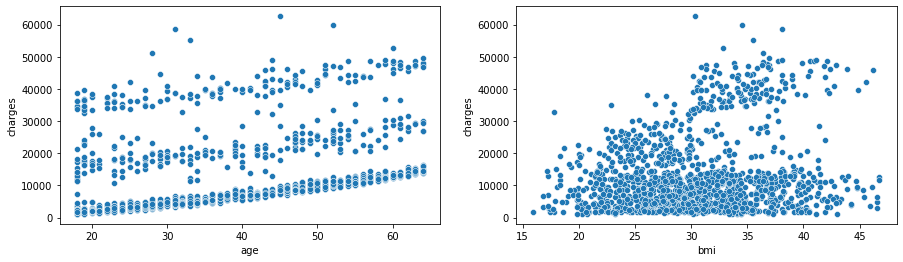

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.scatterplot(ax=ax[0], x="age", y="charges", data=df)
sns.scatterplot(ax=ax[1], x="bmi", y="charges", data=df)
plt.show()

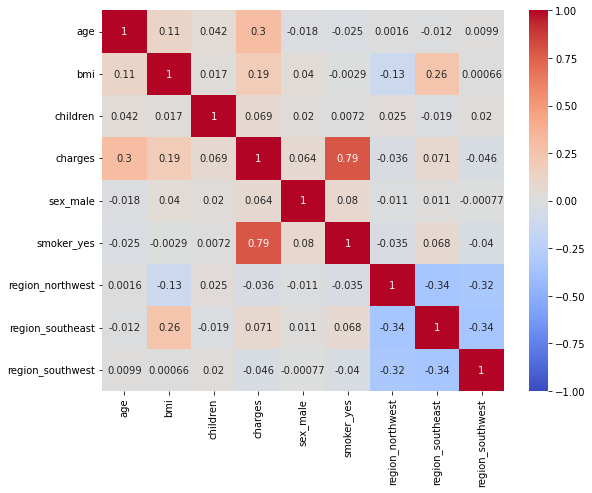

In [17]:
plt.figure(figsize=(9,7))
sns.heatmap(df.corr(), vmin=-1, cmap="coolwarm", annot=True)
plt.show()

We can see that children, sex and region columns have very less correlation with charges (the output). So, we can drop them.

In [18]:
df.drop(['children', 'sex_male', 'region_northwest', 'region_southeast', 'region_southwest'], axis='columns', inplace=True)

### 3.3) Normalization and standardization

In [19]:
df['bmi'] = utils.normalize(df['bmi'])
df['age'] = utils.normalize(df['age'])

In [20]:
# Scaling the output variable (charges) by a factor of 1000
df['charges'] = df['charges']/1000

## 4) Multivariate Linear Regression

### 4.1) Feature-target split

In [21]:
X = df.drop(axis='columns', labels='charges').to_numpy().astype(np.float64)

# Adding a column of ones to the data matrix
n = X.shape[0]
X =  np.c_[ np.ones(n), X] 

y = df['charges'].to_numpy().astype(np.float64)

### 4.2) Train-test split

In [22]:
X_train, X_test, y_train, y_test = utils.train_test_split(X, y, train_size=0.75)

### 4.3) Closed Form

#### 4.3.1) Training 

In [23]:
w = lr.closed_form(X_train, y_train)

In [24]:
yhat_train = lr.predict(X_train, w)
print('Metrics for the training data:')
print('MSE', utils.mean_squared_error(y_train, yhat_train))
print('MAE', utils.mean_absolute_error(y_train, yhat_train))

Metrics for the training data:
MSE 35.771655775715914
MAE 4.051751743574558


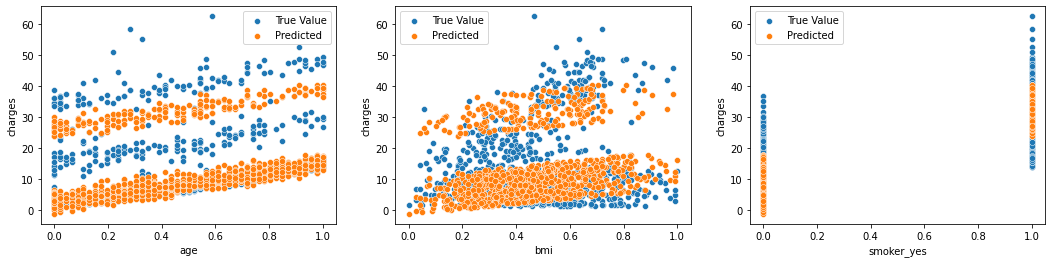

In [25]:
# Plot the results
features = ['age', 'bmi', 'smoker_yes']
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for i in range(1,4):
  sns.scatterplot(ax=ax[i-1], x=X_train[:,i], y=y_train, label = 'True Value')
  sns.scatterplot(ax=ax[i-1], x=X_train[:,i], y=yhat_train, label = 'Predicted')
  ax[i-1].set_xlabel(features[i-1])
  ax[i-1].set_ylabel('charges')
plt.legend()
plt.show()

#### 4.3.2) Testing 

In [26]:
yhat_test = lr.predict(X_test, w)
print('Metrics for test data:')
print('MSE', utils.mean_squared_error(y_test, yhat_test))
print('MAE', utils.mean_absolute_error(y_test, yhat_test))

Metrics for test data:
MSE 38.91835135259444
MAE 4.297047620390672


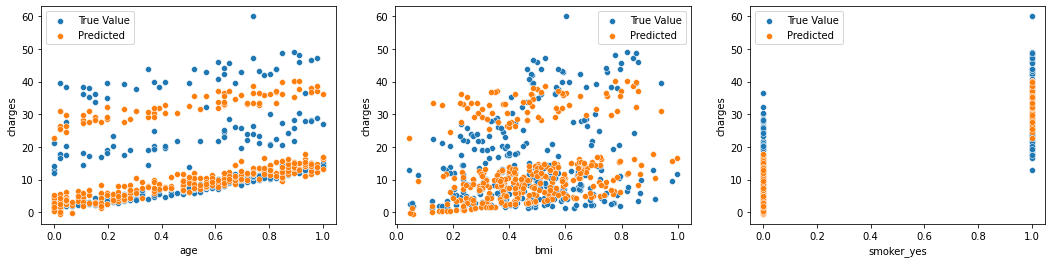

In [27]:
# Plot the results
features = ['age', 'bmi', 'smoker_yes']
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for i in range(1,4):
  sns.scatterplot(ax=ax[i-1], x=X_test[:,i], y=y_test, label = 'True Value')
  sns.scatterplot(ax=ax[i-1], x=X_test[:,i], y=yhat_test, label = 'Predicted')
  ax[i-1].set_xlabel(features[i-1])
  ax[i-1].set_ylabel('charges')
plt.legend()
plt.show()

### 4.4) Gradient Descent

#### 4.4.1) Training 

In [28]:
iters = 1000
w, cost = lr.fit(X_train, y_train, 0.1, iters)

In [29]:
yhat_train = lr.predict(X_train, w)
print('Metrics for the training data:')
print('MSE', utils.mean_squared_error(y_train, yhat_train))
print('MAE', utils.mean_absolute_error(y_train, yhat_train))

Metrics for the training data:
MSE 35.77166925000189
MAE 4.0508238966151175


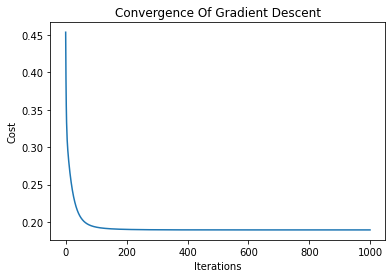

In [30]:
# Convergence of gradient descent
plt.title('Convergence Of Gradient Descent')
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.plot(range(iters), cost)
plt.show()

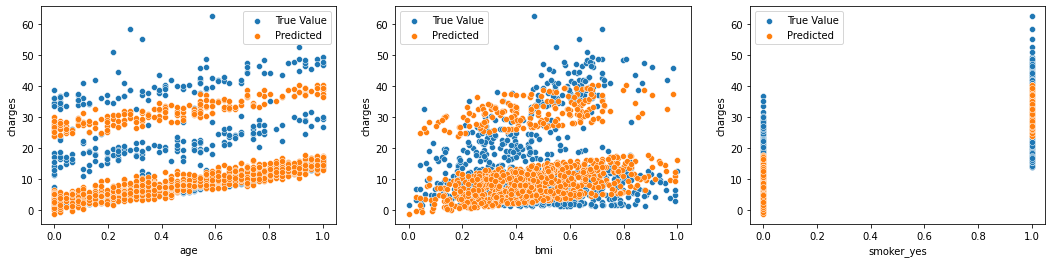

In [31]:
# Plot the results
features = ['age', 'bmi', 'smoker_yes']
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for i in range(1,4):
  sns.scatterplot(ax=ax[i-1], x=X_train[:,i], y=y_train, label = 'True Value')
  sns.scatterplot(ax=ax[i-1], x=X_train[:,i], y=yhat_train, label = 'Predicted')
  ax[i-1].set_xlabel(features[i-1])
  ax[i-1].set_ylabel('charges')
plt.legend()
plt.show()

#### 4.4.1) Testing 

In [32]:
yhat_test = lr.predict(X_test, w)
print('Metrics for test data:')
print('MSE', utils.mean_squared_error(y_test, yhat_test))
print('MAE', utils.mean_absolute_error(y_test, yhat_test))

Metrics for test data:
MSE 38.924897176305684
MAE 4.296693076802595


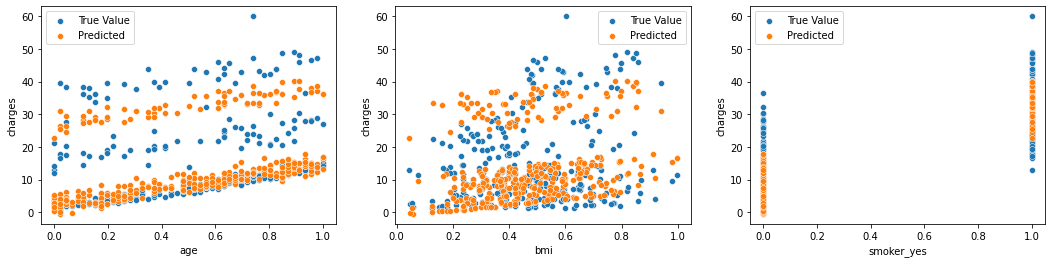

In [33]:
# Plot the results
features = ['age', 'bmi', 'smoker_yes']
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for i in range(1,4):
  sns.scatterplot(ax=ax[i-1], x=X_test[:,i], y=y_test, label = 'True Value')
  sns.scatterplot(ax=ax[i-1], x=X_test[:,i], y=yhat_test, label = 'Predicted')
  ax[i-1].set_xlabel(features[i-1])
  ax[i-1].set_ylabel('charges')
plt.legend()
plt.show()

## 5) Univariate Linear Regression

We'll use age as our input feature and charges as our target variable.

### 5.1) Feature-target split

In [34]:
X = df['age'].to_numpy().astype(np.float64).reshape(-1,1)

# Adding a column of ones to the data matrix
n = X.shape[0]
X =  np.c_[ np.ones(n), X] 

y = df['charges'].to_numpy().astype(np.float64)

### 5.2) Train-test split

In [35]:
X_train, X_test, y_train, y_test = utils.train_test_split(X, y, train_size=0.75)

### 5.3) Closed Form

#### 5.3.1) Training 

In [36]:
w = lr.closed_form(X_train, y_train)

In [37]:
yhat_train = lr.predict(X_train, w)
print('Metrics for the training data:')
print('MSE', utils.mean_squared_error(y_train, yhat_train))
print('MAE', utils.mean_absolute_error(y_train, yhat_train))

Metrics for the training data:
MSE 127.5011961188409
MAE 8.806019232541956


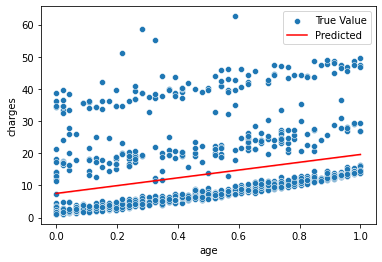

In [38]:
# Plot the results
sns.scatterplot(x=X_train[:,1], y=y_train, label = 'True Value')
sns.lineplot(x=X_train[:,1], y=yhat_train, label = 'Predicted', color='red')
plt.xlabel('age')
plt.ylabel('charges')
plt.legend()
plt.show()

#### 5.3.2) Testing 

In [39]:
yhat_test = lr.predict(X_test, w)
print('Metrics for test data:')
print('MSE', utils.mean_squared_error(y_test, yhat_test))
print('MAE', utils.mean_absolute_error(y_test, yhat_test))

Metrics for test data:
MSE 140.67829898611197
MAE 9.283682117476001


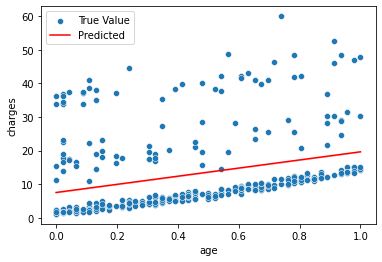

In [40]:
# Plot the results
sns.scatterplot(x=X_test[:,1], y=y_test, label = 'True Value')
sns.lineplot(x=X_test[:,1], y=yhat_test, label = 'Predicted', color='red')
plt.xlabel('age')
plt.ylabel('charges')
plt.legend()
plt.show()

### 5.4) Gradient Descent

#### 5.4.1) Training 

In [41]:
iters = 1000
w, cost = lr.fit(X_train, y_train, 0.1, iters)

In [42]:
yhat_train = lr.predict(X_train, w)
print('Metrics for the training data:')
print('MSE', utils.mean_squared_error(y_train, yhat_train))
print('MAE', utils.mean_absolute_error(y_train, yhat_train))

Metrics for the training data:
MSE 127.50119611884121
MAE 8.806019259751254


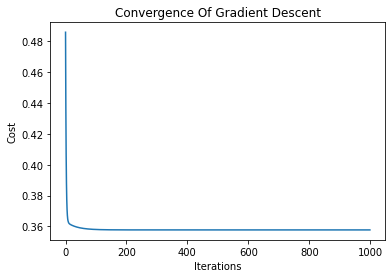

In [43]:
# Convergence of gradient descent
plt.title('Convergence Of Gradient Descent')
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.plot(range(iters), cost)
plt.show()

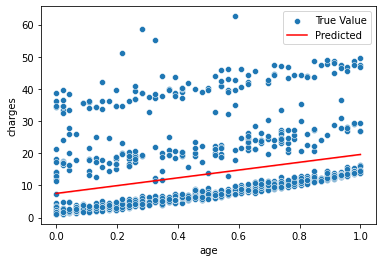

In [44]:
# Plot the results
sns.scatterplot(x=X_train[:,1], y=y_train, label = 'True Value')
sns.lineplot(x=X_train[:,1], y=yhat_train, label = 'Predicted', color='red')
plt.xlabel('age')
plt.ylabel('charges')
plt.legend()
plt.show()

#### 5.4.2) Testing 

In [45]:
yhat_test = lr.predict(X_test, w)
print('Metrics for test data:')
print('MSE', utils.mean_squared_error(y_test, yhat_test))
print('MAE', utils.mean_absolute_error(y_test, yhat_test))

Metrics for test data:
MSE 140.67829855006548
MAE 9.283682127320153


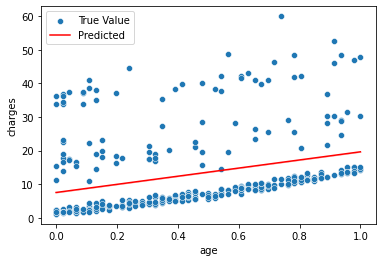

In [46]:
# Plot the results
sns.scatterplot(x=X_test[:,1], y=y_test, label = 'True Value')
sns.lineplot(x=X_test[:,1], y=yhat_test, label = 'Predicted', color='red')
plt.xlabel('age')
plt.ylabel('charges')
plt.legend()
plt.show()